In [1]:
import parabellum as pb
import jax
from jax import grad, jit, vmap, random

2024-06-17 20:31:39.234 python[99359:2829299] ApplePersistence=NO


100%|██████████| 800/800 [00:08<00:00, 89.37it/s]


Moviepy - Building video parabellum.mp4.
Moviepy - Writing video parabellum.mp4



Moviepy - Done !
Moviepy - video ready parabellum.mp4


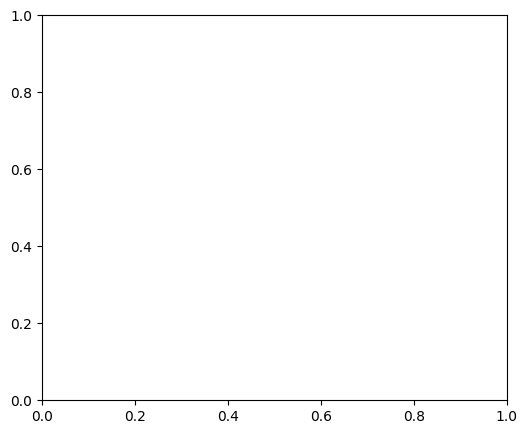

In [2]:
env = pb.Parabellum()
rng, key = random.split(random.PRNGKey(0))
obs, state = env.reset(key)
state_seq = []

for step in range(100):
    rng, key = random.split(rng)
    key_act = random.split(key, len(env.agents))
    actions = {
        agent: env.action_space(agent).sample(key_act[i])
        for i, agent in enumerate(env.agents)
    }
    state_seq.append((key, state, actions))
    rng, key_step = random.split(rng)
    obs, state, reward, done, infos = env.step(key_step, state, actions)

vis = pb.Visualizer(env, state_seq)
clip = vis.animate()